__Batch run for zonal stats__ \
Tips from: https://gorelick.medium.com/fast-er-downloads-a2abd512aa26 \
Here, HydroLakes are the vectors, not BAWLD. Dataset is much larger and complicated.

## I/O

In [45]:
import os
import multiprocessing
import numpy as np
from scipy.stats import binned_statistic

from retry import retry
import geopandas as gpd
import pandas as pd
import dask.dataframe as dd
import ee
import geemap
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
analysis_dir = '/mnt/g/Ch4/GSW_zonal_stats/HL/v0/'
os.makedirs(analysis_dir, exist_ok=True)

In [3]:
## Register with ee using high-valume (and high-latency) endpoint
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

## Functions

In [3]:
def getRequests():
    """Generates a list of work items to be downloaded.
    Funnily enough, equivalent  to np.arange(-179.75, 179.75, 0.5)
    """    
    ## Load vector dataset
    vect = ee.FeatureCollection("projects/sat-io/open-datasets/HydroLakes/lake_poly_v10")

    # For testing: Filter  to reduce size of operation
    vectF = vect.filter("Pour_lat > 59.5").filter("Pour_lat < 59.6") #.filter("Long == -126.25")

    ## Aggregate by Country
    return np.unique(vectF.aggregate_array('Country').getInfo()) # change to bawld not bawldF for real run

In [4]:
@retry(tries=10, delay=1, backoff=2) # (tries=10, delay=1, backoff=2)
def getResult(index, group):
    """Handle the HTTP requests to download one result. index is python index and long is longitude, used for aggregation."""
    ''' TODO: for real, filter to only Arctic, change scale and tile scale, change load gdf BB'''
    ## I/O
    out_dir = os.path.join(analysis_dir, 'tiles')
    out_pth = os.path.join(out_dir, f'HL_zStats_Oc_Country_{group}.csv')

    ## CRS (ist there a smarter way to do this?)
    crs = 'PROJCS["Lambert_Azimuthal_Equal_Area",GEOGCS["Unknown",DATUM["D_unknown",SPHEROID["Unknown",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_origin",45.5],PARAMETER["central_meridian",-114.125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]'
    # crs = 'PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",90],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","6931"]]'

    ## Load vect
    vect = ee.FeatureCollection("projects/sat-io/open-datasets/HydroLakes/lake_poly_v10")

    ## Load GSW
    gsw = ee.Image("JRC/GSW1_4/GlobalSurfaceWater")
    occurrence = gsw.select('occurrence')

    ## Filter based on country bin
    vectF = vect.filter(ee.Filter.eq("Country", group))

    # For testing: Filter  to reduce size of operation
    vectF = vectF.filter("Pour_lat > 59.5").filter("Pour_lat < 59.6") #.filter("Long == -126.25")

    # statistics_type can be either 'SUM' or 'PERCENTAGE'
    # denominator can be used to convert square meters to other areal units, such as square kilometers
    geemap.zonal_statistics_by_group(
        occurrence,
        vectF,
        out_pth,
        statistics_type='SUM',
        denominator=1000000,
        decimal_places=3,
        crs=crs,
        scale=300, # meters, specifiy to compute at native res (default would be 300m)
        tile_scale=2 # default is 1, but it exceeds GEE capacity
    )

    print("Done with Country: ", group)

## Apply functions via GEE calls in parallel

In [6]:
## View expected number of results
items = getRequests()
len(items)


6

In [8]:
## Run function
items = getRequests()
print(f'Sending request in {len(items)} chunks...')
pool = multiprocessing.Pool(25)
pool.starmap(getResult, enumerate(items))
pool.close()
pool.join()

Sending request in 6 chunks...
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... Computing (Hi Ethan!)... Computing (Hi Ethan!)... 


Computing (Hi Ethan!)... 
Generating URL ...
Generating URL ...
Please wait ...
Please wait ...
Generating URL ...
Generating URL ...
Data downloaded to /mnt/g/Ch4/GSW_zonal_stats/HL/v0/tiles/HL_zStats_Oc_Country_Estonia.csv
Done with Country:  Estonia
Data downloaded to /mnt/g/Ch4/GSW_zonal_stats/HL/v0/tiles/HL_zStats_Oc_Country_Sweden.csv
Done with Country:  Sweden
Please wait ...
Please wait ...
Data downloaded to /mnt/g/Ch4/GSW_zonal_stats/HL/v0/tiles/HL_zStats_Oc_Country_Norway.csv
Done with Country:  Norway
Data downloaded to /mnt/g/Ch4/GSW_zonal_stats/HL/v0/tiles/HL_zStats_Oc_Country_United States of America.csv
Done with Country:  United States of America
Generating URL ...
Please wait ...
Data downloaded to /mnt/g/Ch4/GSW_zonal_stats/HL/v0/tiles/HL_zStats_Oc_Country_Russia.csv
Done with Country:  Russia
Generating URL 

## Load and piece together

In [13]:
# Load files using dask
# from https://mungingdata.com/pandas/read-multiple-csv-pandas-dataframe/
tile_dir = os.path.join(analysis_dir, 'tiles')
ddf = dd.read_csv(f"{tile_dir}/*.csv", assume_missing=True, dtype={'system:index': 'object', 'Lake_name': 'object'}) # latter argument suggested by dask error and it fixes it!

In [14]:
## convert to pandas df
df = ddf.compute()
df = df.reset_index().drop('index', axis=1)
df

,Class_70,Class_71,Class_72,Class_73,Class_74,Class_75,Class_76,Class_77,Class_sum,Class_8,...,Continent,Grand_id,Elevation,Vol_res,Dis_avg,Pour_lat,Vol_src,Country,Lake_name,system:index
0,0.000,0.0,0.000,0.000,0.018,0.0,0.000,0.00,0.230,0.0,...,North America,0.0,212.0,0.0,0.030,59.537308,3.0,Canada,NaN,00060000000000001fc0
1,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.00,0.253,0.0,...,North America,0.0,203.0,0.0,0.004,59.555639,3.0,Canada,NaN,00060000000000001f83
2,0.007,0.0,0.000,0.029,0.000,0.0,0.000,0.00,0.742,0.0,...,North America,0.0,104.0,0.0,0.124,59.502014,3.0,Canada,NaN,00060000000000002049
3,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.00,0.172,0.0,...,North America,0.0,196.0,0.0,0.018,59.516580,3.0,Canada,NaN,00060000000000002009
4,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.00,0.102,0.0,...,North America,0.0,236.0,0.0,0.036,59.514027,3.0,Canada,NaN,00060000000000002017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5232,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.00,0.154,0.0,...,North America,0.0,127.0,0.0,0.005,59.506192,3.0,United States of America,NaN,001e0000000000001d5e
5233,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.03,0.181,0.0,...,North America,0.0,9.0,0.0,0.028,59.547652,3.0,United States of America,NaN,001e0000000000001cf6
5234,0.000,0.0,0.000,0.000,0.015,0.0,0.014,0.00,0.109,0.0,...,North America,0.0,53.0,0.0,0.002,59.578082,3.0,United States of America,NaN,001e0000000000001cbe
5235,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.00,0.288,0.0,...,North America,0.0,53.0,0.0,0.179,59.552185,3.0,United States of America,NaN,001e0000000000001ceb


## Bin GSW in 4 bins

In [15]:
## Mask in occurence columns and change values to int
oc_columns = list(map(lambda c: ('Class_' in c) and ('sum' not in c), df.columns)) # occurrence columns positive mask. use map function, rather than for loop, for practice!
oc_column_vals = list(map(lambda c: int(c.replace('Class_', '')), df.columns[oc_columns])) # all relevant occurance fields converted to ints, as a list
oc_column_vals

[70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 8,
 78,
 7,
 79,
 9,
 0,
 2,
 1,
 4,
 3,
 6,
 5,
 80,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 92,
 93,
 94,
 95,
 96,
 97,
 10,
 98,
 11,
 99,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 100,
 90,
 91,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

In [16]:
bStat = binned_statistic(oc_column_vals, values=df.iloc[:, oc_columns], statistic=np.nansum, bins=[0, 5, 50, 95, 100]) # 

In [17]:
bStat

BinnedStatisticResult(statistic=array([[0.015, 0.002, 0.213, 0.   ],
       [0.   , 0.   , 0.253, 0.   ],
       [0.   , 0.001, 0.741, 0.   ],
       ...,
       [0.   , 0.009, 0.1  , 0.   ],
       [0.019, 0.19 , 0.046, 0.   ],
       [0.002, 0.   , 0.062, 0.   ]]), bin_edges=array([  0.,   5.,  50.,  95., 100.]), binnumber=array([3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 1, 1, 1, 1, 1, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 2, 4, 2, 4, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

In [19]:
bin_labels = ['0-5', '5-50', '50-95', '95-100']
dfB = pd.DataFrame(bStat.statistic, columns=bin_labels) / pd.DataFrame(df.loc[:,'Class_sum']).values * 100 #, index=df.index) # df binned
dfB['Hylak_id'] = df.Hylak_id
dfB['Class_sum'] = df.Class_sum
dfB 

,0-5,5-50,50-95,95-100,Hylak_id,Class_sum
0,6.521739,0.869565,92.608696,0.0,665873.0,0.230
1,0.000000,0.000000,100.000000,0.0,665116.0,0.253
2,0.000000,0.134771,99.865229,0.0,667261.0,0.742
3,0.000000,6.976744,93.023256,0.0,666679.0,0.172
4,0.000000,0.000000,100.000000,0.0,666786.0,0.102
...,...,...,...,...,...,...
5232,0.000000,2.597403,97.402597,0.0,667093.0,0.154
5233,27.071823,2.762431,70.165746,0.0,665439.0,0.181
5234,0.000000,8.256881,91.743119,0.0,664241.0,0.109
5235,6.597222,65.972222,15.972222,0.0,665250.0,0.288


## Load shapefile and join in GSW values (full and binned)

In [20]:
## Load shapefile to join
gdf = gpd.read_file('/mnt/f/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp', bbox=(-180, 59.5, 180, 59.6))


ERROR 1: PROJ: proj_create_from_database: Open of /home/ekyzivat/mambaforge/envs/geospatial/share/proj failed


In [28]:
## Filter columns
cols_to_keep = df.columns[[('Class' in c) or ('Hylak_id' in c) for c in df.columns]]


In [29]:

## Merge files
gdf_join_full = gdf.merge(df[cols_to_keep], left_on='Hylak_id', right_on='Hylak_id', how='inner', validate='one_to_one')

In [30]:
## Write out full shapefile
gdf_join_full_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_full.shp')
gdf_join_full.to_file(gdf_join_full_pth)

In [31]:
gdf.columns

Index(['Hylak_id', 'Lake_name', 'Country', 'Continent', 'Poly_src',
       'Lake_type', 'Grand_id', 'Lake_area', 'Shore_len', 'Shore_dev',
       'Vol_total', 'Vol_res', 'Vol_src', 'Depth_avg', 'Dis_avg', 'Res_time',
       'Elevation', 'Slope_100', 'Wshd_area', 'Pour_long', 'Pour_lat',
       'geometry'],
      dtype='object')

In [32]:
## Merge binned file to bawld gdf (only keep a few original attributes)
gdf_join_binned = gdf.merge(dfB, left_on='Hylak_id', right_on='Hylak_id', how='inner', validate='one_to_one') # ['Cell_ID', 'Long', 'Lat', 'Area_Pct', 'Shp_Area', 'WETSCAPE', 'geometry']
gdf_join_binned

,Hylak_id,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,Lake_area,Shore_len,Shore_dev,...,Slope_100,Wshd_area,Pour_long,Pour_lat,geometry,0-5,5-50,50-95,95-100,Class_sum
0,419,Atlin,Canada,North America,CanVec,1,0,589.46,629.06,7.31,...,-1.00,7013.3,-133.813610,59.599259,"POLYGON ((-133.81525 60.02140, -133.81214 60.0...",0.027255,0.092938,10.509432,89.370375,590.717
1,1156,Kubenskoye,Russia,Europe,SWBD,1,0,427.83,302.22,4.12,...,0.97,14501.0,39.795991,59.516493,"POLYGON ((39.07264 59.84195, 39.07125 59.83998...",0.002327,1.622742,10.341578,88.033353,429.828
2,1157,None,Russia,Europe,MODIS,1,0,429.31,393.99,5.36,...,1.20,29512.6,66.242657,59.513625,"POLYGON ((64.79759 59.89509, 64.79830 59.88803...",1.696899,38.086081,24.559259,35.657761,423.832
3,4881,None,Canada,North America,CanVec,1,0,12.76,71.28,5.63,...,1.07,845.9,-95.356400,59.598383,"POLYGON ((-95.41977 59.68040, -95.41661 59.680...",0.007863,0.802076,58.472910,40.717150,12.717
4,4882,Lake Beverley,United States of America,North America,NHD,1,0,90.72,118.08,3.50,...,6.21,1161.0,-158.538201,59.595660,"POLYGON ((-158.97062 59.73147, -158.96703 59.7...",0.071795,0.394323,30.642293,68.844093,90.535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5232,1292162,None,Sweden,Europe,ECRINS,1,0,0.49,3.15,1.27,...,3.03,33.4,13.076042,59.500352,"POLYGON ((13.08899 59.49671, 13.08926 59.49585...",0.000000,26.428571,73.571429,0.000000,0.420
5233,1292163,None,Russia,Europe,SWBD,1,0,0.55,2.98,1.14,...,1.30,1.3,60.316380,59.500158,"POLYGON ((60.32734 59.50136, 60.32763 59.49943...",3.255814,0.000000,96.744186,0.000000,0.215
5234,1292164,None,Russia,Europe,SWBD,1,0,0.18,2.71,1.82,...,0.79,1.5,79.908915,59.500136,"POLYGON ((79.92318 59.49446, 79.92306 59.49375...",0.568182,32.954545,66.477273,0.000000,0.176
5235,1292165,None,Russia,Europe,SWBD,1,0,0.26,1.98,1.10,...,0.66,1.5,81.938398,59.500483,"POLYGON ((81.93430 59.49834, 81.93417 59.49819...",0.000000,0.000000,100.000000,0.000000,0.237


In [8]:
## Write out binned shapefile
gdf_join_binned_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_binned.shp')
gdf_join_binned.to_file(gdf_join_binned_pth)

## Histogram plots

In [13]:
## load if necessary (previously defined vars)
# gdf_join_full_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_full.shp')
# gdf_join_full = gpd.read_file(gdf_join_full_pth)

# gdf_join_binned_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_binned.shp')
# gdf_join_binned = gpd.read_file(gdf_join_binned_pth)

bin_labels = ['0-5', '5-50', '50-95', '95-100']


In [34]:
## Preprocess to remove any nan's in important columns
gdf_join_binnedF = gdf_join_binned.dropna(subset=bin_labels) # filtered
print(f'Dropped {gdf_join_binned.shape[0] - gdf_join_binnedF.shape[0]} rows with nans.')
## Take weighted average
weightAvg = np.average(gdf_join_binnedF[bin_labels], weights = gdf_join_binnedF['Lake_area'], axis=0)
# weightAvg = np.average(gdf_join_binned[bin_labels], axis=0)

weightAvg

Dropped 7 rows with nans.


array([ 0.3996497 ,  5.89231565, 57.87739941, 35.81150505])

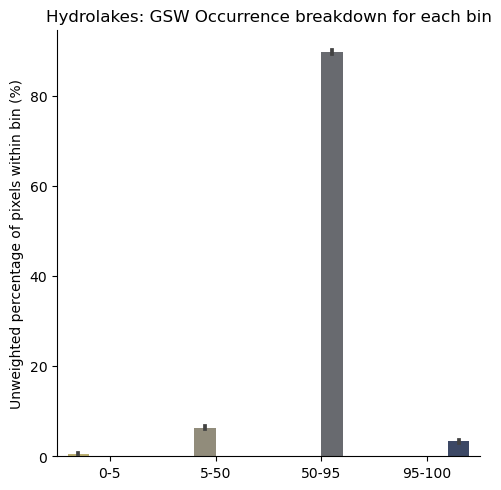

In [62]:
## Plot
## Reshape (melt) and plot as grouped bar plot
"Within all of one occurrence bin, what was the contribution of LEV values"
g = sns.catplot(gdf_join_binned[['Hylak_id']+bin_labels].melt(id_vars='Hylak_id', var_name='Occurrence bin'),\
     hue = 'Occurrence bin', y='value', x='Occurrence bin', kind='bar', palette='cividis_r', errorbar=('ci', 95))
g.set_axis_labels('', 'Unweighted percentage of pixels within bin (%)')
g.set(title=f'Hydrolakes: GSW Occurrence breakdown for each bin')

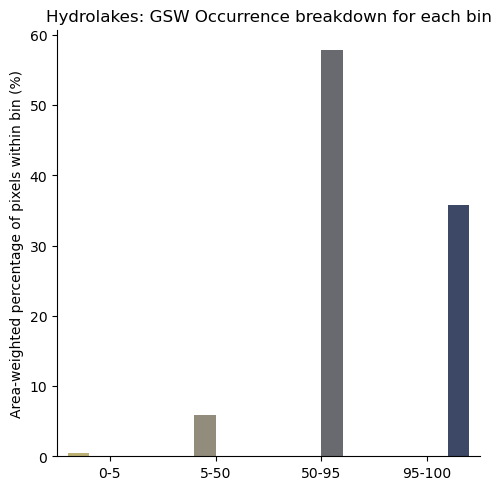

In [61]:
## Weighted average histogram/barplot
dfWA = pd.DataFrame([weightAvg, bin_labels], index=['value','bin']).T
g = sns.catplot(dfWA, hue = 'bin', y='value', x='bin', kind='bar', palette='cividis_r')
g.set_axis_labels('', 'Area-weighted percentage of pixels within bin (%)')
g.set(title=f'Hydrolakes: GSW Occurrence breakdown for each bin')

In [ ]:
## TODO: add sns 95% CI by converting percentages to km2, summing, then normalizing

Text(0, 0.5, 'Unweighted percentage of pixels within bin (%)')

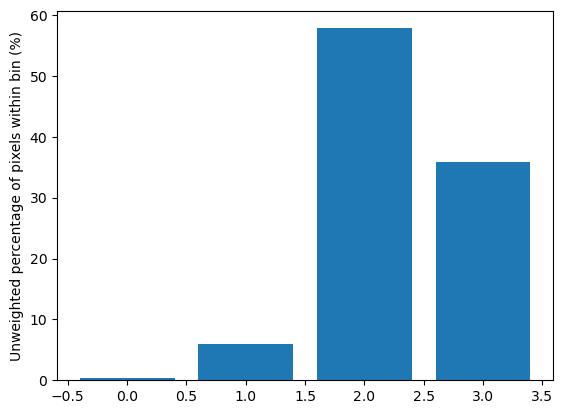

In [50]:
## Weighted average histogram/barplot (alternate using MPL)

plt.bar(x=np.arange(4), height=weightAvg)
plt.ylabel( 'Unweighted percentage of pixels within bin (%)')
